In [70]:
import json
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
from datetime import datetime, timedelta
from scipy.stats import kurtosis, skew

# Remplacez ces valeurs par vos identifiants personnels
access_token = "bddbaa8f7251b0ba039452cb998a3905-aed4d2d69c1d1543dec8e1c3c18b4c65"
accountID = "101-002-30836297-001"

# Initialisation du client API en mode practice (pour live, changez l'environnement si nécessaire)
api = API(access_token=access_token)

# Paramètres pour récupérer les chandelles (candles) journalières de l'instrument XAU_USD
instrument = "XAU_USD"
granularity = "H1"  # D pour Daily

# Paramètres de la requête
params = {
    "from": 1738472400,
    "to": 1739077200,
    "granularity": granularity,
    # "count": 115     # Nombre de chandelles souhaitées
}

# Création de l'endpoint pour récupérer les chandelles
r = instruments.InstrumentsCandles(instrument=instrument, params=params)

# Exécution de la requête via l'API
api.request(r)

# Vérification de la présence de données dans la réponse
if "candles" not in r.response:
    print("Erreur lors de la récupération des données :", r.response)
    exit()

candles = r.response["candles"]
# display(candles)

# Traitement des données : extraction de la date et du prix de clôture pour chaque candle complète
records = []
for candle in candles:
    if candle.get("complete", False):
        time_str    = candle["time"]
        volume = float(candle["volume"])
        open_price = float(candle["mid"]["o"])
        close_price = float(candle["mid"]["c"])
        low_price   = float(candle["mid"]["l"])
        high_price  = float(candle["mid"]["h"])
        records.append({"Date": time_str, 
                        "Open": open_price, 
                        "High": high_price,
                        "Low": low_price, 
                        "Close": close_price, 
                        "Volume": volume,
                        })

# Création d'un DataFrame pandas pour faciliter l'analyse
df = pd.DataFrame(records)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
# display(df)

In [77]:
import mplfinance as mpf
import matplotlib.pyplot as plt

# configure mpf to return fig and axes
fig, axs = mpf.plot(df, type='candle', volume=True, returnfig=True, style='yahoo', mav=(3,6), savefig='candlestick.png')
# plot fig
fig.savefig('candlestick.png')

from io import BytesIO
buffer = BytesIO()
fig.savefig(buffer, format='png')
print(buffer.getvalue())

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02?\x08\x06\x00\x00\x00\x8f\x87\xbd\x92\x00\x00\x00:tEXtSoftware\x00Matplotlib version3.10.0, https://matplotlib.org/\x94rXr\x00\x00\x00\tpHYs\x00\x00\x0fa\x00\x00\x0fa\x01\xa8?\xa7i\x00\x00\xb5\x1cIDATx\x9c\xec\xdd\x07|\x14E\xfb\x07\xf0\xdf\xed\xdd\xa5\x17\x92\x10 \x04\x08%\x10 \xf4. \xbd\x08\x02" \x08\xd8@\x04\xc1\xae\xa0`\xef\xe2_EQ\xc0\x02/\xa2("]zo\n\xd2\xa5\x84\x9a\xd0{(\xe9\xfd\xca\xff3\x13\xee\xc8\xa5\x91\xbawI~\xdf\xf7=\x97\xdb\xdd\xbb\x9d\x9b+\xd9gg\xe6\x19\x8d\xd9l6\x83\x88\x88\x88\x88\x88H\x05\x8a\x1a\x07!"""""\x12\x18\x80\x10\x11\x11\x11\x11\x91j\x18\x80\x10\x11\x11\x11\x11\x91j\x18\x80\x10\x11\x11\x11\x11\x91j\x18\x80\x10\x11\x11\x11\x11\x91j\x18\x80\x10\x11\x11\x11\x11\x91j\x18\x80\x10\x11\x11\x11\x11\x91j\x18\x80\x10\x11\x11\x11\x11\x91j\x18\x80\x10\x11\x11\x11\x11\x91j\x18\x80\x10\x11\x11\x11\x11\x91j\x18\x80\x10\x11\x11\x11\x11\x91j\x18\x80\x10\x11\x11\x11\x11\x91j\x18\x80\x10\x11\x11\x11\x11\x91j\x18\x80\x10

In [40]:

# Calcul des statistiques sur les prix de clôture
prix_cloture   = df["Close"]
moyenne        = prix_cloture.mean()
variance       = prix_cloture.var()
ecart_type     = prix_cloture.std()
asymetrie      = skew(prix_cloture)
kurtosis_exces = kurtosis(prix_cloture)  # Kurtosis en excès (0 pour une distribution normale)

# Affichage des résultats
print(f"\nStatistiques pour l'or (instrument: {instrument}) de {df.index[0]} à {df.index[-1]} :")
print(f"Moyenne de clôture       : {moyenne:.2f} USD")
print(f"Variance                : {variance:.4f}")
print(f"Écart-type              : {ecart_type:.2f}")
print(f"Asymétrie (Skewness)    : {asymetrie:.2f}")
print(f"Kurtosis (excès)        : {kurtosis_exces:.2f}")


Statistiques pour l'or (instrument: XAU_USD) de 2025-02-02 23:00:00+00:00 à 2025-02-07 21:00:00+00:00 :
Moyenne de clôture       : 2843.01 USD
Variance                : 755.8860
Écart-type              : 27.49
Asymétrie (Skewness)    : -0.80
Kurtosis (excès)        : -0.52


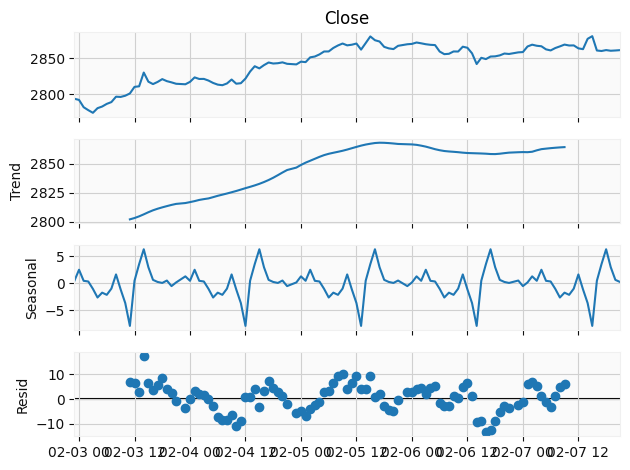

In [59]:
# decomposition en tendance, bruit et saisonnalité
import statsmodels.api as sm
import matplotlib.pyplot as plt

decomposition = sm.tsa.seasonal_decompose(prix_cloture, model='additive', period=24)
fig = decomposition.plot()
plt.show()
# plt save fig 
fig.savefig('decomposition.png')

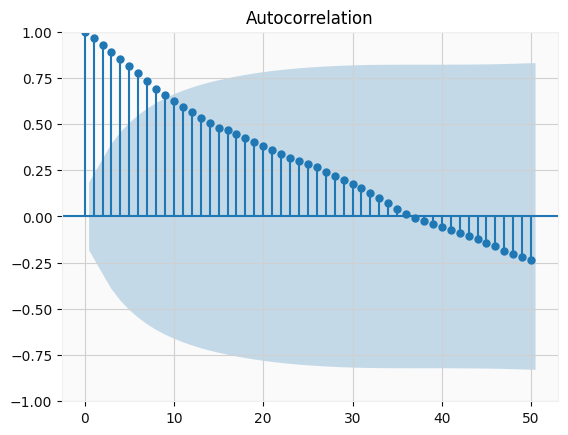

In [44]:
# autocorrélation de la série temporelle prix de cloture
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(prix_cloture, lags=50)
plt.show()
